<a href="https://colab.research.google.com/github/anirbanghoshsbi/Second_Strategy_aka_Meta_labeling/blob/main/experimental/Meta-Label%20simplified-SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
#!pip install --upgrade ta

In [65]:
def get_ta(df_):
    """
    parameters
    df_ (pd.DataFrame): must contain [open,high,low,close,volume] in columns.
    """
    df = df_.copy()
    # assert error
    df.columns = [x.lower() for x in df.columns]
    

    df['m_rsi'] = ta.momentum.rsi(df.close)
    df['m_roc'] = ta.momentum.roc(df.close)
    df['m_cmo'] = get_cmo(df)
    df['m_wr']  = ta.momentum.williams_r(df.high, df.low, df.close)
    df['vm_cmf'] = ta.volume.chaikin_money_flow(df.high, df.low, df.close, df.volume)
    df['vm_mfi'] = ta.volume.money_flow_index(df.high, df.low, df.close, df.volume)
    df['vm_fi'] = ta.volume.force_index(df.close, df.volume)
    df['vm_eom'] = ta.volume.ease_of_movement(df.high, df.low, df.volume)
    df['vl_bbp'] = ta.volatility.bollinger_pband(df.close)
    df['vl_atr'] = ta.volatility.average_true_range(df.high, df.low, df.close)
    #df['t_sma']  = trend.sma_indicator(df.close)
    df['t_macdd']  = ta.trend.MACD(df.close).macd_diff()
    df['t_trix'] = ta.trend.trix(df.close)
    df['t_cci'] = ta.trend.cci(df.high, df.low, df.close)
    df['t_dpo'] = ta.trend.dpo(df.close)  # trend occilator
    df['t_kst'] = ta.trend.kst(df.close)  # know sure thing
    df['t_adx'] = ta.trend.adx(df.high, df.low, df.close)  # adx:strength of trend
            
    return df 


def calculate_CMO(series): 
    sum_gains = series[series >= 0].sum()
    sum_losses = np.abs(series[series < 0].sum())
    cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
    
    return np.round(cmo, 3)

def get_cmo(df, period=13):
    #tmp = df.close.diff().rolling(period).apply(calculate_CMO, args=(period,), raw=True)
    
    tmp = df.close.diff().rolling(period).apply(calculate_CMO, raw=True)
    return tmp


In [66]:
def rsi(close,window=14):
        diff = close.diff(1)
        up_direction = diff.where(diff > 0, 0.0)
        down_direction = -diff.where(diff < 0, 0.0)
        emaup = up_direction.ewm(window, adjust=False).mean()
        emadn = down_direction.abs().ewm(window, adjust=False).mean()
        rs = emaup / emadn
        rsi = pd.Series(np.where(emadn == 0, 100, 100 - (100 / (1 + rs))),
                        index=close.index)
        return pd.Series(rsi, name="rsi")

def get_signal_1(close,n1=10,n2=14):
        one = np.sign((close-close.shift(1)).ewm(n1).mean())
        two = np.sign(rsi(close,n2)-50)
        choindex = one+two
        signal = pd.Series(np.where(choindex.shift(1)==2, 1, 0),index=close.index)
        return signal
    
def get_signal_2(close,n1=10,n2=14):
     one = np.sign((close-close.shift(1)).ewm(n1).mean())
     two = np.sign(rsi(close,n2)-58)
     choindex = one+two
     signal = pd.Series(np.where(choindex.shift(1)==2, 1, 0),index=close.index)
     return signal
 
def sma_crossover_signal(close,fast_window,slow_window):
    sma_crossover = pd.DataFrame(close)
    sma_crossover['fast'] = close.rolling(fast_window).mean()
    sma_crossover['slow'] = close.rolling(slow_window).mean()
    sma_crossover.dropna(inplace=True)
    sma_crossover['madiff'] = np.where(sma_crossover.fast>sma_crossover.slow, 1, 0)
    sma_crossover['signal'] = sma_crossover.madiff.diff()
    signal = sma_crossover.signal
    return signal

def rsi_signal(close,window=14,threshold=30):
    rsi_df = pd.DataFrame(rsi(close,window))
    rsi_df['turn'] = np.where(rsi_df.rsi<threshold,-1,0)
    rsi_signal = rsi_df.turn.diff()
    return rsi_signal

def bb_signal(close,n=20):
    bbsignal = pd.DataFrame(close)
    bbsignal['bbbelow'] = np.where(ta.volatility.bollinger_lband(close,n)>close,-1,0)
    signal = bbsignal.bbbelow.diff().dropna()
    return signal

In [67]:
import plotly.express as px
import plotly.graph_objects as go

def add_vertical_barrier(t_events, close, days=0, hours=0, minutes=0, seconds=0):
    """
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    :param t_events: (pd.Series) Series of events (symmetric CUSUM filter)
    :param close: (pd.Series) Close prices
    :param num_days: (int) Number of days to add for vertical barrier
    :param num_hours: (int) Number of hours to add for vertical barrier
    :param num_minutes: (int) Number of minutes to add for vertical barrier
    :param num_seconds: (int) Number of seconds to add for vertical barrier
    :return: (pd.Series) Timestamps of vertical barriers
    """
    timedelta = pd.Timedelta(
        '{} days, {} hours, {} minutes, {} seconds'.format(days, hours, minutes, seconds))
    # Find index to closest to vertical barrier
    nearest_index = close.index.searchsorted(t_events + timedelta)

    # Exclude indexes which are outside the range of close price index
    nearest_index = nearest_index[nearest_index < close.shape[0]]

    # Find price index closest to vertical barrier time stamp
    nearest_timestamp = close.index[nearest_index]
    filtered_events = t_events[:nearest_index.shape[0]]

    vertical_barriers = pd.Series(data=nearest_timestamp, index=filtered_events)
    return vertical_barriers


def forming_barriers(close, events, pt_sl, molecule): 
    """
    Advances in Financial Machine Learning, Snippet 3.2, page 45.
    Triple Barrier Labeling Method
    This function applies the triple-barrier labeling method. It works on a set of
    datetime index values (molecule). This allows the program to parallelize the processing.
    Mainly it returns a DataFrame of timestamps regarding the time when the first barriers were reached.
    :param close: (pd.Series) Close prices
    :param events: (pd.Series) Indices that signify "events" (see cusum_filter function
    for more details)
    :param pt_sl: (np.array) Element 0, indicates the profit taking level; Element 1 is stop loss level
    :param molecule: (an array) A set of datetime index values for processing
    :return: (pd.DataFrame) Timestamps of when first barrier was touched
    """
    # Apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['exit']].copy(deep=True)

    profit_taking_multiple = pt_sl[0]
    stop_loss_multiple = pt_sl[1]

    # Profit taking active
    if profit_taking_multiple > 0:
        profit_taking = profit_taking_multiple * events_['trgt']
    else:
        profit_taking = pd.Series(index=events.index)  # NaNs

    # Stop loss active
    if stop_loss_multiple > 0:
        stop_loss = -stop_loss_multiple * events_['trgt']
    else:
        stop_loss = pd.Series(index=events.index)  # NaNs

    out['pt'] = pd.Series(dtype=events.index.dtype)
    out['sl'] = pd.Series(dtype=events.index.dtype)

    # Get events
    for loc, vertical_barrier in events_['exit'].fillna(close.index[-1]).iteritems():
        closing_prices = close[loc: vertical_barrier]  # Path prices for a given trade
        cum_returns = (closing_prices / close[loc] - 1) * events_.at[loc, 'side']  # Path returns
        out.at[loc, 'sl'] = cum_returns[cum_returns < stop_loss[loc]].index.min()  # Earliest stop loss date
        out.at[loc, 'pt'] = cum_returns[cum_returns > profit_taking[loc]].index.min()  # Earliest profit taking date

    return out


def get_barrier(close, enter, pt_sl, max_holding, target=None, side=None):
    """
    :param close: (pd.Series) Close prices
    :param enter: (pd.Series) of entry points. These are timestamps that will seed every triple barrier.
        These are the timestamps
    :param pt_sl: (2 element array) Element 0, indicates the profit taking level; Element 1 is stop loss level.
        A non-negative float that sets the width of the two barriers. (if target is not None, pt_sl is ratio)
    :param target: (pd.Series) target rate
    :param max_holding: (2 element list) [days, hours]
    :param side: (pd.Series) Side of the bet (long/short) as decided by the primary model.
        1 if long, -1 if short
    :return: (pd.DataFrame) Events
            -events.index is event's starttime
            -events['exit'] is event's endtime
            -events['side'] implies the algo's position side
            -events['ret'] is return of each bet
    """

    # 1) Get target
    if target is None:
        target_ = pd.Series(1,index=enter)
    
    else:
        target_ = target.reindex(enter)

    # 2) Get vertical barrier (max holding period)
    vertical_barrier = add_vertical_barrier(enter, close, days=max_holding[0], hours=max_holding[1])

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1.0, index=target_.index)
        pt_sl_ = [pt_sl[0], pt_sl[1]]
    else:
        side_ = side.reindex(target_.index)  # Subset side_prediction on target index.
        pt_sl_ = pt_sl[:2]

    # Create a new df
    events = pd.concat({'exit': vertical_barrier, 'trgt': target_,'side': side_}, axis=1)

    # Apply Triple Barrier
    first_touch_dates = forming_barriers(close, events, pt_sl_, events.index)
    

    for ind in events.index:
        events.at[ind, 'exit'] = first_touch_dates.loc[ind, :].dropna().min()

    events_x = events.dropna(subset=['exit'])

    out_df = pd.DataFrame(index=events.index)
    out_df['exit'] = events['exit']
    out_df['price'] = close
    out_df['ret'] = 0
    out_df.loc[events_x.index,'ret'] = (np.log(close.loc[events_x['exit'].array].array) - np.log(close.loc[events_x.index])) * events['side']
    out_df['side'] = events['side']
    return out_df

def grid_pt_sl(pt,sl,close,enter,max_holding,side):
    """
    :param pt: list of profit taking target rate
    :param sl: list of stop loss target rate
    :return: (pd.DataFrame) Cumulative Returns of each pt_sl
            row = profit taking target rate, columns = stop loss target rate
    """
    out = np.ones((len(pt),len(sl)))
    df = pd.DataFrame(out)
    df.index = pt
    df.columns = sl
    for i in pt:
        for j in sl:
            pt_sl = [i,j]
            df.loc[i,j] = get_barrier(close,enter,pt_sl,max_holding,side).ret.cumsum()[-1]
    return df

def get_wallet(close, barrier, initial_money=0, bet_size=None):
    """
    :param close: series of price
    :param barrier: DataFrame from get_barrier()
                barrier must include column 'exit'
    :return: (pd.DataFrame) Cumulative Returns of each pt_sl
            row = profit taking target rate, columns = stop loss target rate
    """
    close = close.round(2)
    if bet_size is None:
        bet_size = pd.Series(np.ones(len(close)),index=close.index)
    bet_amount = bet_size.loc[barrier.index]
    spend = bet_amount*close.loc[barrier.index]
    receive = pd.Series(close.loc[barrier.exit.dropna()].values, index=barrier.dropna(subset=['exit']).index)*bet_amount
    receive = receive.fillna(0)
    close_exit = pd.Series(receive.loc[barrier.index].values,index=barrier.exit).groupby(by='exit',axis=0).sum()
    close_exit = close_exit.rename('money_receive')
    
    wallet_0 = pd.DataFrame({'exit':barrier.exit,'price':close,'money_spent':spend})
    wallet = wallet_0.join(close_exit).fillna(0)
    wallet = wallet.drop(index= wallet.loc[wallet.money_spent+wallet.money_receive==0].index)
    
    buy_amount = bet_amount
    buy_amount = buy_amount.rename('buy_amount')
    sell_amount = (wallet.money_receive/wallet.price).round()
    sell_amount = sell_amount.rename('sell_amount')
    
    n_stock = ((wallet.money_spent/wallet.price).round()-(wallet.money_receive/wallet.price).round()).cumsum()
    n_stock = n_stock.rename('n_stock')
    
    inventory = (-wallet.money_spent+wallet.money_receive).cumsum() + initial_money
    inventory = inventory.rename('cash_inventory')
    
    out = wallet.join([buy_amount,sell_amount,n_stock,inventory])
    out = out.fillna(0)
    return out

def show_results(wallet):
    """
    
    Parameters
    ----------
    wallet : dataframe from get_wallet()
    Returns
    -------
    show results
    """
    initial_invest = wallet.cash_inventory[0]+wallet.money_spent[0]
    cash_in_hand = wallet.cash_inventory[-1]
    stock_owned = wallet.n_stock[-1]
    stock_price_now = wallet.price[-1]
    total_asset = cash_in_hand + stock_owned*stock_price_now
    total_gain = total_asset-initial_invest
    total_return = total_gain/initial_invest
    tcost = wallet.money_receive.sum() * 0.003 + 0 # 0.3% tax, no fee
    
    print("Your initial investment money : {}".format(initial_invest))
    print("You now have cash : {}".format(cash_in_hand))
    print("You now have n of stocks : {}".format(stock_owned))
    print("Your total asset (cash+stock) now : {}".format(total_asset))
    print("Total gain : {}".format(total_gain))
    print("Transaction costs : {}".format(tcost))
    print("Total profit : {}".format(total_gain-tcost))

def get_plot_wallet(close,barrier,wallet):
    
    plot_df = close.to_frame().join(barrier)
    ret_abs = plot_df.ret.abs()
    plot_df['ret_size']=ret_abs
    ret_sign = np.sign(plot_df.ret)
    dfret = ret_sign.to_frame()
    dfret[dfret.ret==1] = 'profit'
    dfret[dfret.ret==-1] = 'loss'
    dfret[dfret.ret==0] = 'exit point'
    plot_df['This bet is']=dfret.ret
    plot_wallet = wallet.join(plot_df.dropna()[['This bet is','ret_size']])
    plot_wallet = plot_wallet.reset_index()
    plot_wallet = plot_wallet.fillna({'This bet is':'exit point','ret_size':0})
    plot_wallet = plot_wallet.rename(columns={'timestamp':'Date'})
    return plot_wallet

def get_metalabel(barrier):
    
    """
    Parameters
    ----------
    barrier : dataframe
        from get_barrier()
    Returns
    -------
    series of meta-label (1 profit(go) 0 loss(pass))
    """
    retsign = np.sign(barrier.ret)
    retsign = retsign.loc[retsign!=0]
    out = .5*(retsign+1)
    out = out.rename('label')
    return out

def plot(close,barrier,wallet):   
    plot_wallet = get_plot_wallet(close,barrier,wallet)
    initial_invest = wallet.cash_inventory[0]+wallet.money_spent[0]
    cash_in_hand = wallet.cash_inventory[-1]
    stock_owned = wallet.n_stock[-1]
    stock_price_now = wallet.price[-1]
    total_asset = cash_in_hand + stock_owned*stock_price_now
    total_gain = total_asset-initial_invest
    total_return = total_gain/initial_invest
    
    fig = px.scatter(plot_wallet, x="Date", y="price", size='buy_amount', color='This bet is'
                     ,size_max=10, hover_data=['exit','n_stock','cash_inventory','money_spent','money_receive'],color_discrete_sequence=["red", "black", "blue"])
    
    fig.update_xaxes(ticklabelmode="period")
    fig.update_layout(title_text='Now having cash + stock value = {}, Total gain = {}'.format(total_asset.round(2),(total_gain).round(2)))
    fig.add_trace(go.Scatter(x=close.index, y=close, mode='lines', name="Close Price",opacity=0.4))
    
    fig.show()

In [68]:
#!pip install yfinance

In [69]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import warnings 
warnings.filterwarnings('ignore')

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import ta



In [70]:
import yfinance as yf
#df = yf.download('SPY','2001-01-01','2021-5-1')

In [71]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,132.000000,132.156250,127.562500,128.812500,86.685638,8737500
2001-01-03,128.312500,136.000000,127.656250,135.000000,90.849564,19431600
2001-01-04,134.937500,135.468750,133.000000,133.546875,89.871704,9219000
2001-01-05,133.468750,133.625000,129.187500,129.187500,86.938004,12911400
2001-01-08,129.875000,130.187500,127.687500,130.187500,87.610992,6625300
...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,413.466339,52182400
2021-04-27,417.929993,418.140015,416.299988,417.519989,413.377228,51303100
2021-04-28,417.809998,419.010010,416.899994,417.399994,413.258423,51238900


In [72]:
close = pd.to_numeric(df.Close)

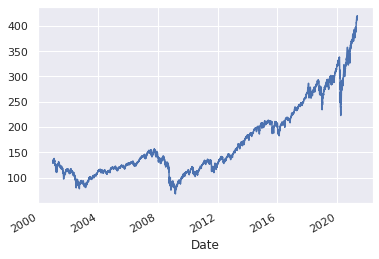

In [73]:
close.plot()

- Sharpe Ratio: $\frac{\mu}{\sigma} = \frac{p\pi+(1-p)(-\pi)}{\sqrt{2\pi p(1-p)}} = \frac{p -0.5}{\sqrt{p(1-p)}}$ 
- $p$ (probability of winning) is given by first model

Triple-Barrier

- why did I choose triple-barrier trading method?
    - I can fix profit and loss symmetrically

In [74]:
f_window = 20
s_window = 60

fema = ta.trend.ema_indicator(close,f_window)
sema = ta.trend.ema_indicator(close,s_window)

diffema = fema-sema
diffema = np.sign(diffema.diff()).dropna()
where = (diffema == 1)

In [75]:
enter = diffema[where].index

In [76]:
enter

DatetimeIndex(['2001-03-30', '2001-04-05', '2001-04-06', '2001-04-09',
               '2001-04-10', '2001-04-11', '2001-04-12', '2001-04-16',
               '2001-04-17', '2001-04-18',
               ...
               '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
               '2021-04-21', '2021-04-23', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='Date', length=2773, freq=None)

In [77]:
pt_sl = [0.05,0.05]

$\pi=0.05$

In [78]:
max_holding = [360,0]

barrier = get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

In [79]:
barrier

,exit,price,ret,side
Date,,,,
2001-03-30,2001-04-03,116.690002,-0.055501,1.0
2001-04-05,2001-04-18,115.050003,0.074915,1.0
2001-04-06,2001-04-17,113.300003,0.051267,1.0
2001-04-09,2001-04-18,114.559998,0.079183,1.0
2001-04-10,2001-04-18,116.650002,0.061104,1.0
...,...,...,...,...
2021-04-23,NaT,416.739990,0.000000,1.0
2021-04-26,NaT,417.609985,0.000000,1.0
2021-04-27,NaT,417.519989,0.000000,1.0


**we will see -1000(test periods) only**

In [80]:
returns = barrier.ret
returns = returns[returns!=0]

In [81]:
returns.describe()

count    2755.000000
mean        0.009034
std         0.055761
min        -0.108301
25%        -0.055795
50%         0.049545
75%         0.052078
max         0.079183
Name: ret, dtype: float64

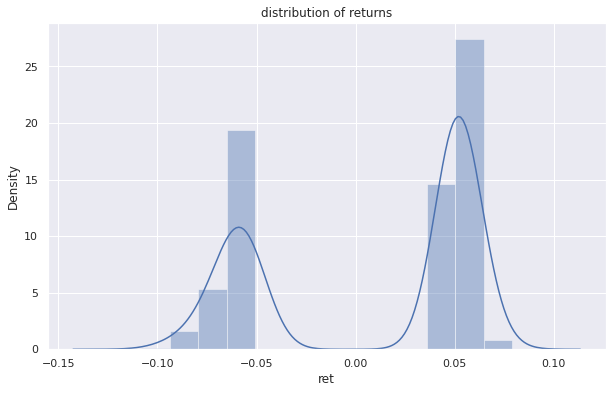

In [82]:
plt.figure(figsize=(10,6))
seaborn.distplot(returns)
plt.title('distribution of returns')
plt.show()

In [83]:
y_ = np.sign(returns).rename('pnl')
y_test = y_.iloc[-1000:]
y_test.value_counts()
#profit and loss

 1.0    673
-1.0    327
Name: pnl, dtype: int64

In [84]:
p = y_test.value_counts().iloc[0]/(y_test.value_counts().iloc[0]+y_test.value_counts().iloc[1])
print('Probabilities of winning (p): ',p)

Probabilities of winning (p):  0.673


In [85]:
asr = np.sqrt(len(y_test))*(p-0.5)/np.sqrt(p*(1-p))
print('Total Sharpe Ratio: ',asr)

Total Sharpe Ratio:  11.661775985836027


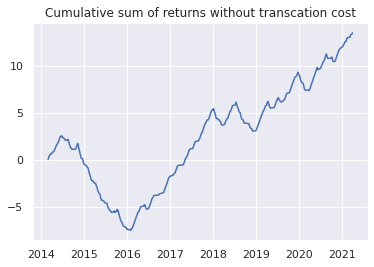

In [86]:
plt.plot(returns.loc[y_test.index].cumsum())
plt.title('Cumulative sum of returns without transcation cost')
plt.show()

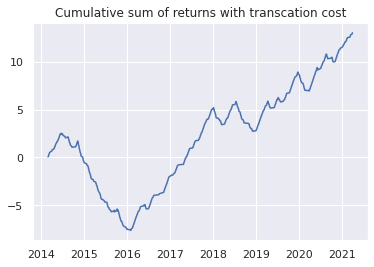

In [87]:
plt.plot((returns.loc[y_test.index]-0.0005).cumsum())
plt.title('Cumulative sum of returns with transcation cost')
plt.show()

# Improve Sharpe ratio by meta-labeling

- drop loss-predicted bets
- prediction by Machine Learning method (Random Forest Classifier)

- NEED precision score > probability of winning of 1st model

### X
- 21 technical indicators features

In [88]:
df_ = df.drop(columns='Adj Close').iloc[:,:5]
list= []
for i in df_.columns:
    list.append(i.lower())
df_.columns = list

In [89]:
TI = get_ta(df_).shift(1).iloc[:,4:].dropna()

In [90]:
TI

,volume,m_rsi,m_roc,m_cmo,m_wr,vm_cmf,vm_mfi,vm_fi,vm_eom,vl_bbp,vl_atr,t_macdd,t_trix,t_cci,t_dpo,t_kst,t_adx
Date,,,,,,,,,,,,,,,,,
2001-03-07,6917000.0,41.391823,-5.444724,-29.199,-63.211553,0.095492,34.446373,-3.013060e+06,75.965110,0.318648,2.687741,-0.379747,-0.237680,-44.611162,1.486495,-65.232018,28.790793
2001-03-08,6371700.0,44.381002,-2.622692,-31.642,-55.564983,0.153108,39.142589,-1.763403e+06,-4.419486,0.395773,2.587188,-0.140437,-0.242901,-36.267458,-0.103000,-58.831159,27.840948
2001-03-09,6055000.0,44.852185,-0.989171,-18.959,-43.710623,0.171833,39.078487,-1.390389e+06,5.268313,0.425713,2.480960,0.043718,-0.243344,-26.416494,-2.494497,-59.023624,26.859360
2001-03-12,10020300.0,36.025085,-1.799078,-26.404,-82.854092,0.155874,38.276230,-6.574097e+06,-62.215131,0.176043,2.590178,-0.065339,-0.245665,-78.338804,-1.816502,-60.068923,26.957551
2001-03-13,13972900.0,27.762391,-6.144182,-34.972,-97.024329,0.115593,36.565477,-1.617450e+07,-152.294784,-0.091118,2.805879,-0.449314,-0.256557,-177.599689,-1.978501,-65.493150,28.272159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,73209200.0,65.331900,2.496371,34.017,-11.751043,0.352810,66.356066,4.455038e+07,11.671894,0.787002,4.294857,-0.003883,0.221666,83.882256,0.317491,57.451246,26.764451
2021-04-27,52182400.0,66.157157,2.225104,34.851,-5.000119,0.306349,66.061565,4.467153e+07,5.390611,0.791206,4.093797,-0.013682,0.222043,95.171789,2.205994,57.394081,27.169416
2021-04-28,51303100.0,65.982181,1.465406,30.222,-6.448856,0.291899,60.431944,3.763030e+07,-1.058035,0.768876,3.932813,-0.079692,0.221616,89.409794,1.269019,57.111906,27.340116


In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
TI_norm = pd.DataFrame(scaler.fit_transform(TI),index=TI.index)

In [92]:
from sklearn.decomposition import PCA
pca = PCA(10)
TI_pc = pd.DataFrame(pca.fit_transform(TI_norm),index=TI.index)
TI_pc

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2001-03-07,2.367584,2.181919,-1.090865,7.765633,-0.843942,-1.942976,1.761774,1.491960,1.938961,0.761776
2001-03-08,2.223511,1.015815,-0.551355,0.202982,1.579127,0.722457,0.207811,-0.047863,1.439913,-0.662308
2001-03-09,1.442066,1.579748,-1.028288,0.580820,1.141115,0.060624,0.489159,0.629718,1.658573,-0.625392
2001-03-12,3.385641,-0.051327,-0.714954,-5.492880,3.277850,2.270080,-0.557738,-1.207083,1.318685,-1.234258
2001-03-13,5.893709,-1.977193,0.092482,-13.504091,6.275578,5.336043,-2.034963,-2.949314,0.711817,-2.465097
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,-2.672984,-0.364192,1.432463,0.888691,-0.733597,-0.224504,1.760108,-0.560070,0.580852,-0.034405
2021-04-27,-2.583708,-0.622165,1.666321,0.749681,-0.290136,0.440323,1.415278,-0.907911,0.169240,-0.051286
2021-04-28,-2.258344,-0.766231,1.535492,0.107452,-0.059245,0.505898,1.342942,-0.734186,0.095657,-0.493403


In [93]:
tmp = TI_pc.join(y_).dropna()
X = tmp.iloc[:,:-1]
y = tmp.iloc[:,-1]

In [94]:
X_train = X.iloc[:-500]
X_test = X.iloc[-500:]

y_train = y.iloc[:-500]
y_test = y.iloc[-500:]

In [95]:
X_test

,0,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,,
2017-11-27,-2.646481,-0.461953,0.973869,0.649123,0.586661,0.828098,-0.627589,0.348580,0.898492,-0.642879
2017-11-28,-2.143822,-0.366968,0.610178,0.374820,0.488526,0.438269,-0.513961,0.481791,0.622572,-0.752444
2017-11-29,-3.537573,0.203155,1.209635,0.567861,0.270977,0.115426,-0.790329,0.414643,0.619562,-1.174722
2017-11-30,-3.281297,0.140329,1.084472,0.371567,0.563494,0.022701,-0.476494,0.314505,0.603525,-0.789654
2017-12-01,-4.127709,0.630099,1.379931,0.172274,0.456546,-0.521970,-0.492072,0.196556,0.427807,-0.398933
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,-2.008013,1.618094,-0.369188,0.742341,-1.634162,1.868687,0.856774,-1.027159,-0.929141,0.244476
2021-03-26,0.894523,-0.269482,0.139154,-1.606897,-1.203738,1.995887,0.839733,-0.547120,-0.925292,0.078007
2021-03-29,-0.978702,0.840162,0.169128,3.555961,-2.694159,0.989752,1.098939,-0.544245,-0.623151,0.282088


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [97]:
clf = RandomForestClassifier(criterion='entropy')#,class_weight='balanced_subsample')

In [98]:
n_estimators = [500,1000]
max_depth = [2, 5]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth)

gs = GridSearchCV(clf, param_grid = param_grid, scoring ='precision')

In [99]:
gs.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': [2, 5], 'n_estimators': [500, 1000]},
             scoring='precision')

In [100]:
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=500)

In [101]:
y_pred = gs.predict(X_test)
y_pred = pd.Series(y_pred, index=X_test.index).rename('y_pred')
y_pred.head()

Date
2017-11-27    1.0
2017-11-28    1.0
2017-11-29    1.0
2017-11-30    1.0
2017-12-01    1.0
Name: y_pred, dtype: float64

In [102]:
from sklearn.metrics import precision_score

In [103]:
p2 = precision_score(y_test,y_pred)
print('Precision score (Probability of winning after drop predicted loss): {}'.format(p2))

Precision score (Probability of winning after drop predicted loss): 0.7004608294930875


In [104]:
# After drop predicted loss
y_2nd = y_test.drop(index=y_pred.loc[y_pred==-1].index)

y_2nd.value_counts()

 1.0    304
-1.0    130
Name: pnl, dtype: int64

In [105]:
p2 = y_2nd.value_counts().iloc[0]/(y_2nd.value_counts().iloc[0]+y_2nd.value_counts().iloc[1])
print('Probabilities of winning (p): ',p2)

Probabilities of winning (p):  0.7004608294930875


In [106]:
asr = np.sqrt(len(y_2nd))*(p2-0.5)/np.sqrt(p2*(1-p2))
print('Total Sharpe Ratio: ',asr)

Total Sharpe Ratio:  9.117077560208994


In [107]:
returns2 = returns.loc[y_2nd.index]

In [108]:
returns2

Date
2017-11-27    0.049443
2017-11-28    0.049176
2017-11-29    0.049785
2017-11-30    0.053628
2017-12-01    0.049643
                ...   
2021-03-16    0.049186
2021-03-17    0.049119
2021-03-26    0.049009
2021-03-30    0.052171
2021-03-31    0.051462
Name: ret, Length: 434, dtype: float64

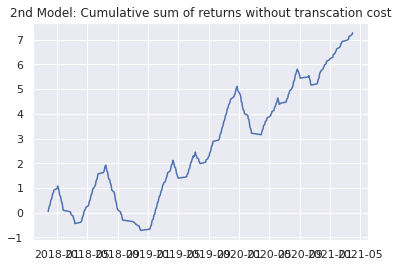

In [109]:
plt.plot((returns2-0.0005).cumsum())
plt.title('2nd Model: Cumulative sum of returns without transcation cost')
plt.show()

Results

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

And,

keep opportunities as many as possible
- n is also important
- let the model do not lose many opportunities
- but how? - further study needed